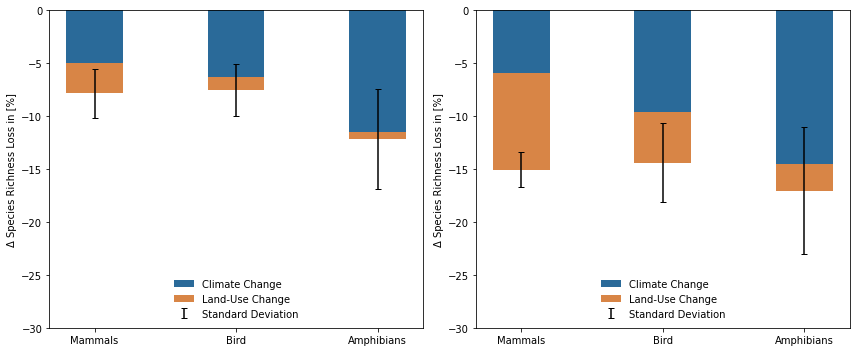

In [37]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
             # Calculate the difference
                min_threshold = 1e-6  # Adjust this threshold based on your data

                non_zero_mask = newvalue_hist_sum_taxa != 0

                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                difference = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered) / newvalue_hist_sum_taxa_filtered * 100
                climate_change = difference.where((difference >= -100) & (difference <= 100))
                
                climate_change = climate_change.where(non_zero_mask, np.nan)

                
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered) / sum_bin_hist_sum_taxa_filtered * 100
                climate_land_change = difference.where((difference >= -100) & (difference <= 100))


                climate_land_change = climate_land_change.where(non_zero_mask, np.nan)

                

                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0)
                climate_change_loss = climate_change.where(climate_change < 0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'Standard Deviation'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=0, bottom=-30)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
#    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


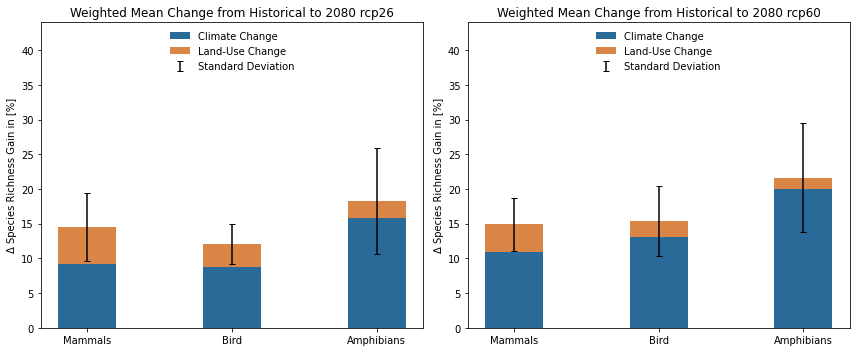

In [3]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data
                non_zero_mask = newvalue_hist_sum_taxa != 0

                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                difference = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered) / newvalue_hist_sum_taxa_filtered * 100
                climate_change = difference.where((difference >= -100) & (difference <= 100))
                
                climate_change = climate_change.where(non_zero_mask, np.nan)

                
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered) / sum_bin_hist_sum_taxa_filtered * 100
                climate_land_change = difference.where((difference >= -100) & (difference <= 100))


                climate_land_change = climate_land_change.where(non_zero_mask, np.nan)

                
               # climate_land_change= climate_land_change * 100     
                climate_change_loss = climate_change.where(climate_change > 0)
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Standard Deviation')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'Standard Deviation'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='upper center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


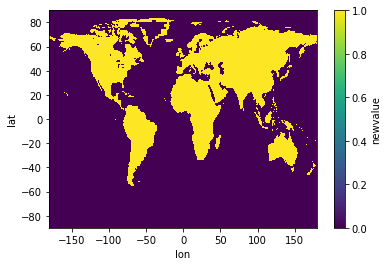

In [6]:
non_zero_mask.plot()

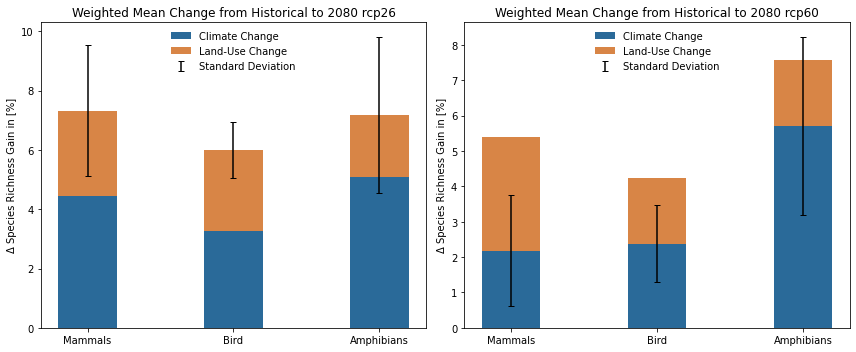

In [42]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data
                non_zero_mask = newvalue_hist_sum_taxa != 0

                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                difference = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered) / newvalue_hist_sum_taxa_filtered * 100
                climate_change = difference.where((difference >= -100) & (difference <= 100))
                
                climate_change = climate_change.where(non_zero_mask, np.nan)

                
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered) / sum_bin_hist_sum_taxa_filtered * 100
                climate_land_change = difference.where((difference >= -100) & (difference <= 100))


                climate_land_change = climate_land_change.where(non_zero_mask, np.nan)




                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change
                
                gcm_data_newvalue.append(climate_change)
                gcm_data_sum_bin.append(climate_land_change)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Standard Deviation')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'Standard Deviation'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:


    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='upper center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


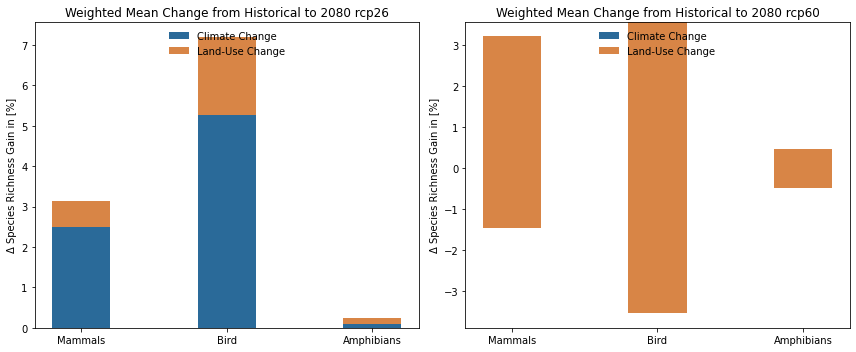

In [30]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data
                non_zero_mask = newvalue_hist_sum_taxa != 0

                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                climate_change = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa) 
       #         climate_change = difference.where((difference >= -100) & (difference <= 100))
                
                climate_change = climate_change.where(non_zero_mask, np.nan)

                
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                climate_land_change = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa)
           #     climate_land_change = difference.where((difference >= -100) & (difference <= 100))


                climate_land_change = climate_land_change.where(non_zero_mask, np.nan)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change
                
                gcm_data_newvalue.append(climate_change)
                gcm_data_sum_bin.append(climate_land_change)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)


    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:


    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='upper center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [24]:
mean_climate_change

array(0.45487402)

In [37]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
newvalue_hist = {}
newvalue_fut = {}


weighted_mean_newvalue_change_hist = {}
weighted_mean_newvalue_change_fut = {}


final_weighted_mean_newvalue_change_hist = {}
final_weighted_mean_newvalue_change_fut = {}


for scenario in scenarios:
    newvalue_hist[scenario] = {}
    newvalue_fut[scenario] = {}
    
    weighted_mean_newvalue_change_hist[scenario] = {}
    weighted_mean_newvalue_change_fut[scenario] = {}
    
    final_weighted_mean_newvalue_change_hist[scenario] = {}
    final_weighted_mean_newvalue_change_fut[scenario] = {}
    
    for taxa in taxas: 
        newvalue_hist[scenario][taxa]={}
        newvalue_fut[scenario][taxa] = {}
 
        
        weighted_mean_newvalue_change_hist[scenario][taxa] = {}
        weighted_mean_newvalue_change_fut[scenario][taxa] = {}
        
        sdm_data_newvalue_hist = []
        sdm_data_newvalue_fut = []
        
        for sdm in sdms:
            newvalue_hist[scenario][taxa][sdm] = {}
            newvalue_fut[scenario][taxa][sdm] = {}

            
            gcm_data_newvalue_hist = []
            gcm_data_newvalue_fut = []

            for gcm in gcms:
                # Load pickle files
                newvalue_hist[scenario][taxa][sdm][gcm] = {}
                newvalue_fut[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
                
                newvalue_hist[scenario][taxa][sdm][gcm] =  sum_bin_hist_sum_taxa
                newvalue_fut[scenario][taxa][sdm][gcm] = sum_bin_future_sum_taxa

                # Append specific data, not the entire dictionary
                gcm_data_newvalue_hist.append(sum_bin_hist_sum_taxa)
                gcm_data_newvalue_fut.append(sum_bin_future_sum_taxa)


                
            # Convert lists to xarray DataArrays
            gcm_data_newvalue_hist_xr = xr.concat(gcm_data_newvalue_hist, dim='gcm')
            gcm_data_newvalue_fut_xr = xr.concat(gcm_data_newvalue_fut, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change_hist[scenario][taxa][sdm] = gcm_data_newvalue_hist_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_newvalue_change_fut[scenario][taxa][sdm] = gcm_data_newvalue_fut_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue_hist.append(weighted_mean_newvalue_change_hist[scenario][taxa][sdm])
            sdm_data_newvalue_fut.append(weighted_mean_newvalue_change_fut[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_hist_xr = xr.concat(sdm_data_newvalue_hist, dim='sdm')
        sdm_data_newvalue_fut_xr = xr.concat(sdm_data_newvalue_fut, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change_hist[scenario][taxa] = sdm_data_newvalue_hist_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_newvalue_change_fut[scenario][taxa] = sdm_data_newvalue_fut_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


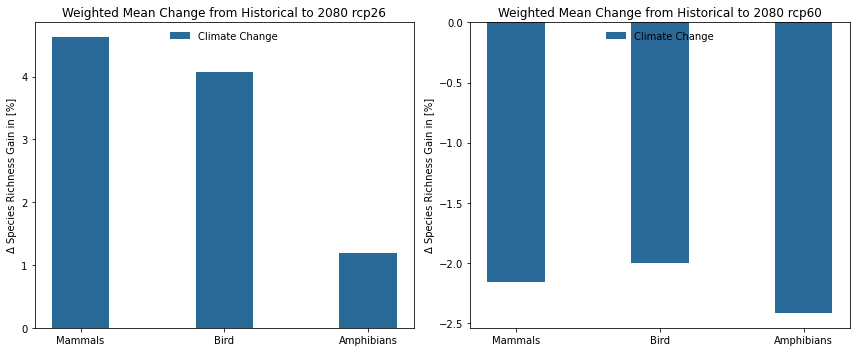

In [38]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        
      #  mean_climate_change = final_weighted_mean_newvalue_change_fut[scenario][taxa].mean().values  -  final_weighted_mean_newvalue_change_hist[scenario][taxa].mean().values
        difference = (final_weighted_mean_newvalue_change_fut[scenario][taxa].mean().values -final_weighted_mean_newvalue_change_hist[scenario][taxa].mean().values) 
        mean_climate_change = difference /final_weighted_mean_newvalue_change_hist[scenario][taxa].mean().values *100
      #  mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
       # std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
         #   handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            #handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Standard Deviation')

            # Extend the scenario-specific lists
          #  scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
          #  scenario_labels.extend(['Climate Change', 'Land-Use Change', 'Standard Deviation'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
         #   ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
          #  ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
   # ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='upper center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [32]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Displaying the created weights fo
# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}

for scenario in scenarios:
    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []
    


    for sdm in sdms:
        mean_newvalue_hist[scenario][sdm] = {}
        mean_newvalue_fut[scenario][sdm] = {}
        mean_sumbin_hist[scenario][sdm] = {}
        mean_sumbin_fut[scenario][sdm] = {}
        
        dataarrays_newvalue_hist = []
        dataarrays_newvalue_fut = []
        dataarrays_sumbin_hist = []
        dataarrays_sumbin_fut = []

        for gcm in gcms:
            mean_newvalue_hist[scenario][sdm][gcm] = {}
            mean_newvalue_fut[scenario][sdm][gcm] = {}
            mean_sumbin_hist[scenario][sdm][gcm] = {}
            mean_sumbin_fut[scenario][sdm][gcm] = {}
            
            sum_newvalue_hist = None
            sum_newvalue_future = None
            sum_sumbin_hist = None
            sum_sumbin_future = None

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pickle.load(f)

     # Sum across taxa
                if sum_newvalue_hist is None:
                    sum_newvalue_hist = newvalue_hist_taxa
                    sum_newvalue_future = newvalue_future_taxa
                    sum_sumbin_hist = sum_bin_hist_taxa
                    sum_sumbin_future = sum_bin_future_taxa
                else:
                    sum_newvalue_hist += newvalue_hist_taxa
                    sum_newvalue_future += newvalue_future_taxa
                    sum_sumbin_hist += sum_bin_hist_taxa
                    sum_sumbin_future += sum_bin_future_taxa
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                    
            # Assign the summed values to your dictionary
            mean_newvalue_hist[scenario][sdm][gcm] = sum_newvalue_hist
            mean_newvalue_fut[scenario][sdm][gcm] = sum_newvalue_future
            mean_sumbin_hist[scenario][sdm][gcm] = sum_sumbin_hist
            mean_sumbin_fut[scenario][sdm][gcm] = sum_sumbin_future

            dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][sdm][gcm])
            dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][sdm][gcm])
            dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][sdm][gcm])
            dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][sdm][gcm])

        # Concatenate and calculate the mean over the new dimension
        mean_over_sdms_gcms_hist[scenario][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').mean(dim='gcm')
        mean_over_sdms_gcms_fut[scenario][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').mean(dim='gcm')
        mean_over_sdms_gcms_sumbin_hist[scenario][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').mean(dim='gcm')
        mean_over_sdms_gcms_sumbin_fut[scenario][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').mean(dim='gcm')

               # Append the mean DataArrays across GCMs to the SDM lists
        dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][sdm])
        dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][sdm])
        dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][sdm])
        dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][sdm])

    # Concatenate and calculate the mean over SDMs
    mean_over_all_sdms_gcms_hist[scenario] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_fut[scenario] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 
    


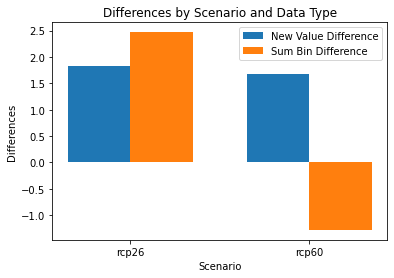

In [35]:
import matplotlib.pyplot as plt

# Assuming the final mean calculations are done as per your code

# Initialize lists to store the differences for plotting
diff_newvalue_list = []
diff_sumbin_list = []
scenarios_for_plot = []

for scenario in scenarios:
    scenarios_for_plot.append(scenario)
    
    # Calculate the differences
    diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
    diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

    # Append the mean of the differences to the lists
    diff_newvalue_list.append(diff_newvalue.mean().item())  # Assuming diff_newvalue is an xarray DataArray
    diff_sumbin_list.append(diff_sumbin.mean().item())      # Assuming diff_sumbin is an xarray DataArray

# Create the bar plot
x = np.arange(len(scenarios_for_plot)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, diff_newvalue_list, width, label='New Value Difference')
rects2 = ax.bar(x + width/2, diff_sumbin_list, width, label='Sum Bin Difference')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scenario')
ax.set_ylabel('Differences')
ax.set_title('Differences by Scenario and Data Type')
ax.set_xticks(x)
ax.set_xticklabels(scenarios_for_plot)
ax.legend()

plt.show()


In [30]:
scenarios_for_plot

['rcp26']